### LBM Inference (original)

In [ ]:
import argparse
import logging
import os

import torch
from PIL import Image

from lbm.inference import evaluate, get_model

save_dir = "/code/LBM/examples/inference/ckpts/relighting"
model = get_model(
    f"jasperai/LBM_relighting",
    save_dir=save_dir,
    torch_dtype=torch.bfloat16,
    device="cuda",
)

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fetching 7 files: 100%|██████████| 7/7 [00:00<00:00, 8577.31it/s]
The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


In [ ]:
source_image = Image.open("/code/LBM/assets/source_image.jpg").convert("RGB")
num_inference_steps = 1
output_image = evaluate(model, source_image, num_inference_steps)

In [ ]:
output_image

### LBM Inference (level 1)

In [ ]:
import logging
import os
from typing import List, Optional

import torch
import yaml
from diffusers import FlowMatchEulerDiscreteScheduler
from huggingface_hub import snapshot_download
from safetensors.torch import load_file

from lbm.models.embedders import (
    ConditionerWrapper,
    LatentsConcatEmbedder,
    LatentsConcatEmbedderConfig,
)
from lbm.models.lbm import LBMConfig, LBMModel
from lbm.models.unets import DiffusersUNet2DCondWrapper
from lbm.models.vae import AutoencoderKLDiffusers, AutoencoderKLDiffusersConfig
from lbm.inference import evaluate


def _get_model_from_config(
    backbone_signature: str = "stabilityai/stable-diffusion-xl-base-1.0",
    vae_num_channels: int = 4,
    unet_input_channels: int = 4,
    timestep_sampling: str = "log_normal",
    selected_timesteps: Optional[List[float]] = None,
    prob: Optional[List[float]] = None,
    conditioning_images_keys: Optional[List[str]] = [],
    conditioning_masks_keys: Optional[List[str]] = [],
    source_key: str = "source_image",
    target_key: str = "source_image_paste",
    bridge_noise_sigma: float = 0.0,
    logit_mean: float = 0.0,
    logit_std: float = 1.0,
    pixel_loss_type: str = "lpips",
    latent_loss_type: str = "l2",
    latent_loss_weight: float = 1.0,
    pixel_loss_weight: float = 0.0,
    torch_dtype: torch.dtype = torch.bfloat16,
    **kwargs,
):

    conditioners = []

    denoiser = DiffusersUNet2DCondWrapper(
        in_channels=unet_input_channels,  # Add downsampled_image
        out_channels=vae_num_channels,
        center_input_sample=False,
        flip_sin_to_cos=True,
        freq_shift=0,
        down_block_types=[
            "DownBlock2D",
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D",
        ],
        mid_block_type="UNetMidBlock2DCrossAttn",
        up_block_types=["CrossAttnUpBlock2D", "CrossAttnUpBlock2D", "UpBlock2D"],
        only_cross_attention=False,
        block_out_channels=[320, 640, 1280],
        layers_per_block=2,
        downsample_padding=1,
        mid_block_scale_factor=1,
        dropout=0.0,
        act_fn="silu",
        norm_num_groups=32,
        norm_eps=1e-05,
        cross_attention_dim=[320, 640, 1280],
        transformer_layers_per_block=[1, 2, 10],
        reverse_transformer_layers_per_block=None,
        encoder_hid_dim=None,
        encoder_hid_dim_type=None,
        attention_head_dim=[5, 10, 20],
        num_attention_heads=None,
        dual_cross_attention=False,
        use_linear_projection=True,
        class_embed_type=None,
        addition_embed_type=None,
        addition_time_embed_dim=None,
        num_class_embeds=None,
        upcast_attention=None,
        resnet_time_scale_shift="default",
        resnet_skip_time_act=False,
        resnet_out_scale_factor=1.0,
        time_embedding_type="positional",
        time_embedding_dim=None,
        time_embedding_act_fn=None,
        timestep_post_act=None,
        time_cond_proj_dim=None,
        conv_in_kernel=3,
        conv_out_kernel=3,
        projection_class_embeddings_input_dim=None,
        attention_type="default",
        class_embeddings_concat=False,
        mid_block_only_cross_attention=None,
        cross_attention_norm=None,
        addition_embed_type_num_heads=64,
    ).to(torch_dtype)

    # NOT USED IN RELIGHTING
    # print(
    #     conditioning_images_keys != [] or conditioning_masks_keys != [],
    #     "conditioning_images_keys != [] or conditioning_masks_keys != []",
    # )
    # if conditioning_images_keys != [] or conditioning_masks_keys != []:

    #     latents_concat_embedder_config = LatentsConcatEmbedderConfig(
    #         image_keys=conditioning_images_keys,
    #         mask_keys=conditioning_masks_keys,
    #     )
    #     latent_concat_embedder = LatentsConcatEmbedder(latents_concat_embedder_config)
    #     latent_concat_embedder.freeze()
    #     conditioners.append(latent_concat_embedder)

    # Wrap conditioners and set to device
    conditioner = ConditionerWrapper(
        conditioners=conditioners,
    )

    ## VAE ##
    # Get VAE model
    vae_config = AutoencoderKLDiffusersConfig(
        version=backbone_signature,
        subfolder="vae",
        tiling_size=(128, 128),
    )
    vae = AutoencoderKLDiffusers(vae_config).to(torch_dtype)
    vae.freeze()
    vae.to(torch_dtype)

    ## Diffusion Model ##
    # Get diffusion model
    config = LBMConfig(
        source_key=source_key,
        target_key=target_key,
        latent_loss_weight=latent_loss_weight,
        latent_loss_type=latent_loss_type,
        pixel_loss_type=pixel_loss_type,
        pixel_loss_weight=pixel_loss_weight,
        timestep_sampling=timestep_sampling,
        logit_mean=logit_mean,
        logit_std=logit_std,
        selected_timesteps=selected_timesteps,
        prob=prob,
        bridge_noise_sigma=bridge_noise_sigma,
    )

    sampling_noise_scheduler = FlowMatchEulerDiscreteScheduler.from_pretrained(
        backbone_signature,
        subfolder="scheduler",
    )

    model = LBMModel(
        config,
        denoiser=denoiser,
        sampling_noise_scheduler=sampling_noise_scheduler,
        vae=vae,
        conditioner=conditioner,
    ).to(torch_dtype)

    return model


model_dir = "/code/LBM/examples/inference/ckpts/relighting"
torch_dtype = torch.bfloat16
device = "cuda"

config = {
    "backbone_signature": "stabilityai/stable-diffusion-xl-base-1.0",
    "vae_num_channels": 4,
    "unet_input_channels": 4,
    "timestep_sampling": "custom_timesteps",
    "selected_timesteps": [250, 500, 750, 1000],
    "prob": [0.25, 0.25, 0.25, 0.25],
    "conditioning_images_keys": [],
    "conditioning_masks_keys": [],
    "source_key": "source_image",
    "target_key": "source_image_paste",
    "bridge_noise_sigma": 0.005,
}
model = _get_model_from_config(**config, torch_dtype=torch_dtype)

# sd = load_file(os.path.join(model_dir, "model.safetensors"))
# model.load_state_dict(sd, strict=True)

model.to(device).to(torch_dtype)

model = model.eval()
None

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


False conditioning_images_keys != [] or conditioning_masks_keys != []


The config attributes {'clip_sample': False, 'sample_max_value': 1.0, 'set_alpha_to_one': False, 'skip_prk_steps': True} were passed to FlowMatchEulerDiscreteScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


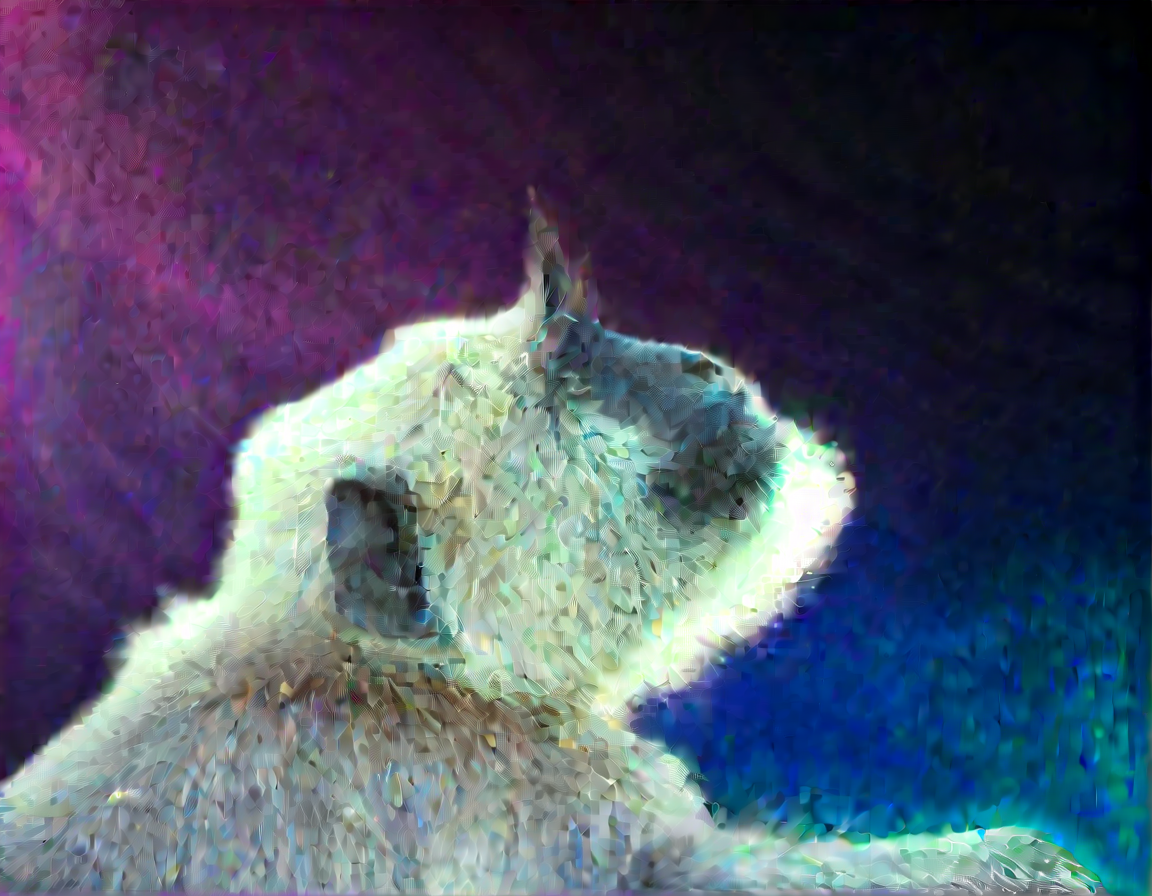

In [2]:
from PIL import Image

source_image = Image.open("/code/LBM/assets/source_image.jpg").convert("RGB")
num_inference_steps = 1
output_image = evaluate(model, source_image, num_inference_steps)
output_image

In [5]:
import numpy as np

np.array(source_image).shape

(896, 1152, 3)